# Lab 3: Ensemble Approaches

In this notebook, we are going to be focusing on the Random Forest Ensemble method. As you learned in the class, Random Forest is an Ensemble approach where an algorithm acts as a group of experts analysing your data and the results is the aggregation of those individual analyses. 

A quick refresher on the theory:
- Random Forest is based on Decision Trees -> many trees = a forest!
- Grows multiple trees on random subsets of the parent dataset
- At every split, a new random subset of features is chosen
- This leads to "decorrelated" trees which leads to a large increase in performance!


First step is to import the libraries we want to use. Notice there is a new one below - sklearn.ensemble.

Sklearn is a suite of libraries that contain a range of machine learning tools. Today we are taking the RandomForestRegressor from the sklearn ensemble library. For more information on sklearn, check out there [diagram](http://scikit-learn.org/stable/tutorial/machine_learning_map/) for when and where to use difference machine learning methods.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from ggplot import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time
import re
plt.style.use('ggplot')
%matplotlib inline

# the command below means that the output of multiple commands in a cell will be output at once.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# the command below tells jupyter to display up to 80 columns, this keeps everything visible
pd.set_option('display.max_columns', 80)
pd.set_option('expand_frame_repr', True)


To get more information about a new modules you have imported, run the cell below. A window containing a description of the module will appear! This provides details on the module parameters and attributes and links for further references. Try it out!

In [2]:
RandomForestRegressor?

You can also visit their page on [RandomForestReggresors](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), or visit their helpful [User Guide](http://scikit-learn.org/stable/modules/ensemble.html#forest) for Ensemble Approaches.

Next we import the entire dataset and the kiva data dictionary

In [3]:
df=pd.read_csv('../../data/df.csv', low_memory=False)

## What questions should we ask?
To begin with we need to think about what question are we trying to answer with our Random Forest algorithms.

In this notebook we will focus predominantly on the Regressor module so that we can compare our results to the previous class. **Therefore, we will be looking at how we can predict the loan amount using RandomForestRegressor.**

However, Random Forest can also be used to classify data, for example some interesting classification questions we could investigate are:
- Can we classify which loans expired and which one got funded?
- Is a loan posted by a male or female?

Feel free to investigate these on your own time! Here is a very simple example of how the RandomForestClassifier works: https://bicorner.com/2015/10/26/random-forest-using-ipython/

Let's start with **loan amount** and see if we can predict how much is requested to be funed using the RandomForestRegressor! 

## Creating Explanatory Features of Interest
For the sake of comparison we will use similar features as in the previous class where we used linear regression to predict the number of days to fund. The code to produce these features is given below but please refer back to Lab 2 if you need any further explanation.

In [4]:
## Male/Female 
df['male'] = df['borrowers'].apply(lambda x: x.split("gender': '")[1][0]=='M')
## Whether or not the borrower is widowed
df['widowed'] = np.where(df['description.texts.en'].str.contains("widowed|widow", na=False) ==True, True, False)
## Whether or not the borrower has children 
df['kids'] = np.where(df['description.texts.en'].str.contains("kids|child|children|kid|son|daughter", na=False) ==True,True,False)
## Features of the loan posting
## Does the borrower include a video? 
df['video'] = np.where(pd.isnull(df['video.id']) ==False, True, False)
## Does the borrower include a picture? 
df['pictured'] = df['borrowers'].apply(lambda x: x.split("gender': '")[1][0]==True)

Time to fund, disperse or expire

In [5]:
df = df.rename(columns={'terms.disbursal_date': 'disbursal_date'})

## convert columns to datetime format
df['funded_date_cln'] = pd.to_datetime(df.funded_date.str[:10], infer_datetime_format=True)
df['post_date_cln'] = pd.to_datetime(df.posted_date.str[:10], infer_datetime_format=True)
df['disb_date_cln'] = pd.to_datetime(df.disbursal_date.str[:10], infer_datetime_format=True)
df['exp_date_cln'] = pd.to_datetime(df.planned_expiration_date.str[:10], infer_datetime_format=True)

## Time to fund is the funded date minus the posted date
df['time_to_fund'] =df['funded_date_cln'] - df['post_date_cln']
df['days_to_fund'] = df.time_to_fund.dt.days

## Time to dispursement is the Disbursed date minus the Posted Date
df['time_to_disb'] =df['disb_date_cln'] - df['post_date_cln']
df['days_to_disb'] = df.time_to_disb.dt.days

## Time to expiration is the expiration date minus the Posted Date
df['time_to_exp'] =df['exp_date_cln'] - df['post_date_cln']
df['days_to_exp'] = df.time_to_exp.dt.days

# Create two variables one for lattitude and one for longitude
df['lat'] = df['location.geo.pairs'].apply(lambda x: x.split()[0])
df['long'] = df['location.geo.pairs'].apply(lambda x: x.split()[1])

In [6]:
# convert strs to datetimes
for col in df.columns:
    if "_date" in col:
        df[col] = pd.to_datetime(df[col])
        col_root = col.split('_date')[0]
        df[col_root+"_year"] = df[col].apply(lambda x: x.year)
        df[col_root+"_month"] = df[col].apply(lambda x: x.month)
        df[col_root+"_unix"] = df[col].apply(lambda x: time.mktime(x.timetuple()) if not pd.isnull(x) else 0)

In [7]:
# number of loans posted in a given month
num_posted = pd.DataFrame(df.groupby(['posted_month', 'posted_year']).count()['activity'])
num_posted.columns = ['num_posted']
# number of loans expired in a given month
num_expired = pd.DataFrame(df[df['status']=='expired'].groupby(['posted_month', 'posted_year']).count()['activity'])
num_expired.columns = ['num_expired']
# mean loan in a given month
mean_loan = pd.DataFrame(df.groupby(['posted_month', 'posted_year']).mean()['loan_amount'])
mean_loan.columns = ['mean_loan']
# mean loan of expired loans in that month
mean_expired_loan = pd.DataFrame(df[df['status']=='expired'].groupby(['posted_month', 'posted_year']).mean()['loan_amount'])
mean_expired_loan.columns = ['mean_expired_loan']
# Adding these to the dataframe
df = df.merge(num_posted, left_on=['posted_month', 'posted_year'], right_index=True, how='outer')
df = df.merge(num_expired, left_on=['posted_month', 'posted_year'], right_index=True, how='outer')
df = df.merge(mean_loan, left_on=['posted_month', 'posted_year'], right_index=True, how='outer')
df = df.merge(mean_expired_loan, left_on=['posted_month', 'posted_year'], right_index=True, how='outer')
# calculating relative loan
df['relative_loan'] = df['loan_amount'] / df['mean_loan']

In [8]:
mean_loan.sort_index(level = ['posted_year','posted_month'],inplace=True)
mean_loan

,,mean_loan
posted_month,posted_year,
4,2006,225.000000
5,2006,391.666667
6,2006,430.392157
7,2006,374.193548
8,2006,310.227273
9,2006,435.714286
10,2006,330.555556
11,2006,701.181102
12,2006,615.373563


Lets plot a line graph of the mean loan over time. There are some interesting results here.

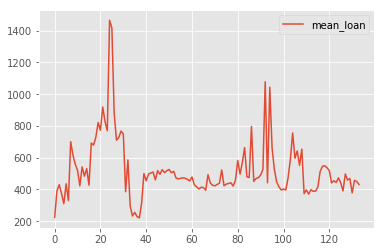

In [9]:
plt.plot(mean_loan['mean_loan'].values, label='mean_loan')
plt.legend()
plt.show()

In [10]:
# Some additional text features from the use description
df['motor'] = df['use'].apply(lambda x: 1 if type(x)==str and 'motor' in x.lower() else 0)
df['more'] = df['use'].apply(lambda x: 1 if type(x)==str and 'more' in x.lower() else 0)
df['solar'] = df['use'].apply(lambda x: 1 if type(x)==str and 'to purchase a solar light ' in x.lower() else 0)
df['num_tags'] = df['tags'].apply(lambda x: x.count(','))

Let's now list the features that we want to use in the random forest algorithm.
Sklearn's RandomForestRegressor can only handle boolean or numeric variables, so we will need to one-hot encode
some of the string variables.

In [12]:
cols = df[['loan_amount', 'num_tags','lat', 'long','days_to_fund','days_to_exp','borrower_count','posted_unix','activity', 'location.town', 'partner_id', "sector", "tags", 'male', 'widowed', 'kids', 'video', 'pictured', 'num_posted', 'motor', 'more', 'solar']]
rf_trainArr = cols.copy()
rf_trainArr = rf_trainArr.dropna()
# These is the corresponding array of results we are trying to predict
rf_trainRes = rf_trainArr['loan_amount']
rf_trainArr = rf_trainArr.drop('loan_amount', axis=1)
rf_trainArr.columns

Index(['num_tags', 'lat', 'long', 'days_to_fund', 'days_to_exp',
       'borrower_count', 'posted_unix', 'activity', 'location.town',
       'partner_id', 'sector', 'tags', 'male', 'widowed', 'kids', 'video',
       'pictured', 'num_posted', 'motor', 'more', 'solar'],
      dtype='object')

One of the features here is tags which includes a range of different tags, lets look at these:

In [13]:
rf_trainArr['tags'].value_counts()

[]                                                                                                                                                                                                                                                                                                                                       37149
[{'name': '#Woman Owned Biz'}, {'name': '#Parent'}]                                                                                                                                                                                                                                                                                       3215
[{'name': 'user_favorite'}]                                                                                                                                                                                                                                                                                                               

Lets create some boolean variables for tags that we think may be interesting and seperate them out into individual features

In [14]:
tag_vals = ["#Woman Owned Biz", "#Parent", "user_favorite", "#Repeat Borrower", "#Schooling", "volunteer_pick", "#Vegan", "volunteer_like","#Animals", "#Eco-friendly", "#Technology"]
for tag in tag_vals:
    if tag not in rf_trainArr.columns:
        rf_trainArr['tag_'+str(tag)] = rf_trainArr['tags'].apply(lambda x: 1 if tag in x else 0)


In [15]:
rf_trainArr = rf_trainArr.drop(['tags'], axis=1)

In addition, there are some features which have a large range of possible responses. Instead of using each possible response as a features, we will just take the top 10. So example, lets look at the top activities:

In [16]:
rf_trainArr['activity'].value_counts().index[0:10]

Index(['Farming', 'Dairy', 'Fruits & Vegetables', 'Agriculture', 'Retail',
       'General Store', 'Clothing Sales', 'Poultry', 'Cereals', 'Food Stall'],
      dtype='object')

The following code takes the top ten occurences for activity, partner_id, location.town and sector and creates a features for each one

In [17]:
cols_to_separate = ['activity','partner_id','location.town','sector']
for col in cols_to_separate:
    col_vals = rf_trainArr[col].value_counts().index[:10]
    for col_val in col_vals:
        if col_val not in rf_trainArr.columns:
            rf_trainArr[col+'_'+str(col_val)] = rf_trainArr[col].apply(lambda x: 1 if x == col_val else 0)
    rf_trainArr = rf_trainArr.drop(col, axis=1)


Lets check our list of features again to make sure the code above worked correctly

In [18]:
rf_trainArr.columns

Index(['num_tags', 'lat', 'long', 'days_to_fund', 'days_to_exp',
       'borrower_count', 'posted_unix', 'male', 'widowed', 'kids', 'video',
       'pictured', 'num_posted', 'motor', 'more', 'solar',
       'tag_#Woman Owned Biz', 'tag_#Parent', 'tag_user_favorite',
       'tag_#Repeat Borrower', 'tag_#Schooling', 'tag_volunteer_pick',
       'tag_#Vegan', 'tag_volunteer_like', 'tag_#Animals', 'tag_#Eco-friendly',
       'tag_#Technology', 'activity_Farming', 'activity_Dairy',
       'activity_Fruits & Vegetables', 'activity_Agriculture',
       'activity_Retail', 'activity_General Store', 'activity_Clothing Sales',
       'activity_Poultry', 'activity_Cereals', 'activity_Food Stall',
       'partner_id_133.0', 'partner_id_164.0', 'partner_id_138.0',
       'partner_id_156.0', 'partner_id_202.0', 'partner_id_388.0',
       'partner_id_203.0', 'partner_id_386.0', 'partner_id_277.0',
       'partner_id_324.0', 'location.town_Likoni', 'location.town_Nakuru',
       'location.town_Kisii', 

## Training the algorithm
The next stage is training and testing the algorithm! To do this we need to create two subsets of data, one which we will train the algorithm on and the other we can test it on. To do this we will use the sklearn model selection function train_test_split. If you look back to the top of this page, we imported this function at the beginning of the notebook.

The names used below (X_train, X_test, y_train, y_test) are the conventions for training and testing data so best to try and train yourselves to use them.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(rf_trainArr, rf_trainRes, test_size=0.2, random_state=42)

### Decision Tree
Before we get into some of the more sophisticated models, let's first try an individual Decision Tree and see how it performs.  After training the model, we will be able to assess it's performance by using sklearns useful method .score, which calculates the r2 value for the data provided.  We will first print out the r2 score for the training data, and then will print out the r2 score for the test data.

In [54]:
from sklearn.tree import DecisionTreeRegressor
decision_regressor = DecisionTreeRegressor(random_state=0)
decision_regressor.fit(X_train, y_train)
print("Train score: " + str(decision_regressor.score(X_train, y_train)))
print("Test score: " + str(decision_regressor.score(X_test, y_test)))

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best')

Train score: 0.99913624501
Test score: 0.437263483671


## Bagging
The decison tree regressor is near perfect on the train data; however, much worse on the test data.  This is largely due to an individual Trees likelihood of overfitting to the data.  To overcome this, let's try building a collection of trees with sklearn's BaggingRegressor.  A bagging regressor builds some specified number of trees and trains each tree with a random subset of the data and then averages the forecast of each individual tree.

In [59]:
from sklearn.ensemble import BaggingRegressor
bagging_regressor = BaggingRegressor(oob_score=True)
bagging_regressor.fit(X_train, y_train)
print("Train score: " + str(bagging_regressor.score(X_train, y_train)))
print("Test score: " + str(bagging_regressor.score(X_test, y_test)))

/Users/j/virtualenvs/delta/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:986: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=True, random_state=None,
         verbose=0, warm_start=False)

Train score: 0.921252033676
Test score: 0.508019419281


Due to the fact that we only consider a random subset of the data for each tree, we can also measure error using the out-of-bag score.  The out-of-bag score calculates the error for each observation that was not used while training an individual tree (Remember ~2/3 of data are used to train a given tree).

In [60]:
bagging_regressor.oob_score_

0.39789253136556046

In [65]:
# Since we will evaluate a few models, let's define a function that prints out the scores we care about
def print_scores(regressor, X_train, y_train, X_test, y_test, oob_score=True):
    print("Train score: " + str(regressor.score(X_train, y_train)))
    print("Test score: " + str(regressor.score(X_test, y_test)))
    print("OOB score: " + str(regressor.oob_score_))

Let's see how performance changes when we increase the number of trees from 10 to 100.

In [66]:
bagging_regressor = BaggingRegressor(n_estimators=100, oob_score=True)
bagging_regressor.fit(X_train, y_train)
print_scores(bagging_regressor, X_train, y_train, X_test, y_test, oob_score=True)

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
         verbose=0, warm_start=False)

Train score: 0.950786697281
Test score: 0.534224876975
OOB score: 0.62040002502


## Random Forest
We still observe a large discrepancy between the training data and the test data.  This is largely because the decision trees are largely correlated.  To de-correlate the trees, we can use a Random Forest Regressor, which only considers a random subsample of the features at each split.

In [67]:
rf_regressor = RandomForestRegressor(n_estimators=100, oob_score=True)
rf_regressor.fit(X_train,y_train)
print_scores(rf_regressor, X_train, y_train, X_test, y_test, oob_score=True)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

Train score: 0.947006777017
Test score: 0.520856606471
OOB score: 0.615019768431


Another metric to evaluate the model on is the mean square error. Again this compares the predicted values to the true values and returns the mean square error for that data. 

391445.68453402759

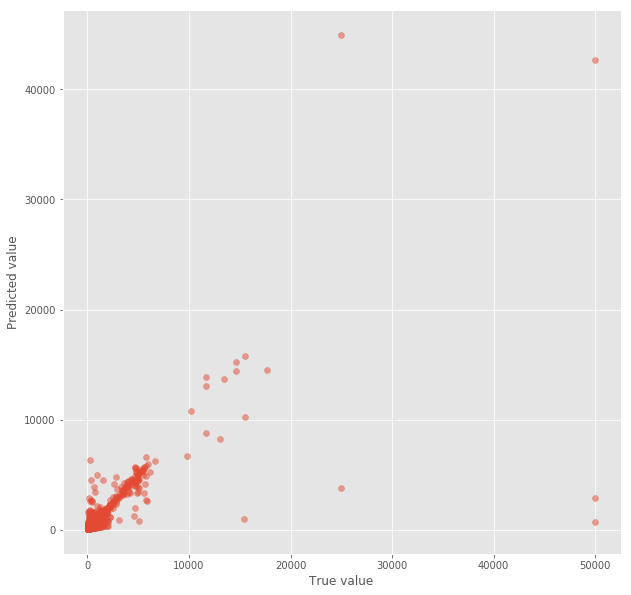

In [72]:
y_predicted_test = rf_regressor.predict(X_test)
mean_squared_error(y_test, y_predicted_test)

fig = plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_predicted_test, alpha=0.5)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.show()

(array([  1.54010000e+04,   1.34300000e+03,   7.40000000e+01,
          1.70000000e+01,   2.40000000e+01,   3.00000000e+01,
          2.00000000e+01,   3.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   3.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          3.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

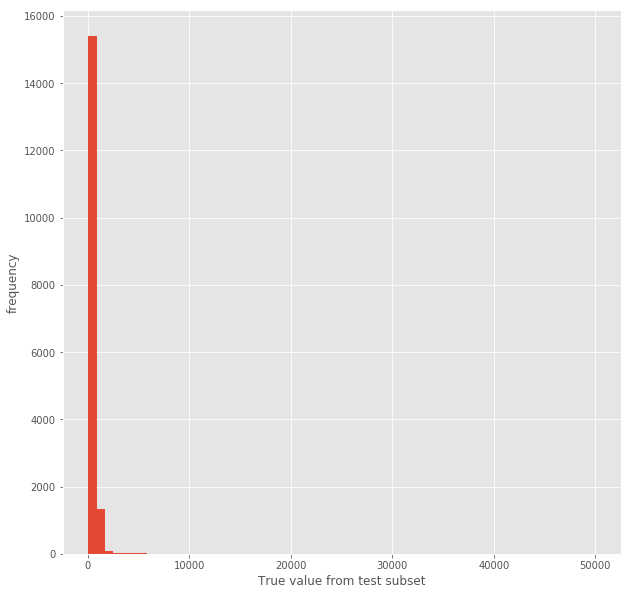

In [73]:
fig = plt.figure(figsize=(10, 10))
plt.hist(y_test, bins=60)
plt.xlabel('True value from test subset')
plt.ylabel('frequency')
plt.show()

Now, let's try to figure out which features are driving our model's predictions.  Although we do not have the coefficients provided by a linear regression, we can analyze what percentage of the overall variance was explained by a given feature.

In [71]:
importances = rf_regressor.feature_importances_
indices = np.argsort(importances)[::-1]

print('Feature Ranking:')
for f in range(len(importances)):
    print("%d. feature %s (%f)" % (f + 1, rf_trainArr.columns[indices[f]], importances[indices[f]]))

Feature Ranking:
1. feature posted_unix (0.197576)
2. feature borrower_count (0.109317)
3. feature video (0.098986)
4. feature days_to_fund (0.084424)
5. feature more (0.076034)
6. feature lat (0.058117)
7. feature num_posted (0.049227)
8. feature num_tags (0.048620)
9. feature long (0.040373)
10. feature tag_#Eco-friendly (0.029950)
11. feature sector_Education (0.029329)
12. feature kids (0.016291)
13. feature male (0.015311)
14. feature tag_#Technology (0.015239)
15. feature partner_id_202.0 (0.013693)
16. feature sector_Retail (0.012984)
17. feature location.town_Nakuru (0.011355)
18. feature days_to_exp (0.009979)
19. feature partner_id_156.0 (0.009600)
20. feature tag_#Parent (0.009361)
21. feature tag_user_favorite (0.008832)
22. feature sector_Agriculture (0.004271)
23. feature activity_Agriculture (0.003593)
24. feature sector_Personal Use (0.003395)
25. feature partner_id_203.0 (0.003045)
26. feature sector_Health (0.002976)
27. feature partner_id_324.0 (0.002674)
28. feature

Let's try taking the top 20 featuers and observe it's impact on performance

In [36]:
relevant_cols = [rf_trainArr.columns[indices[f]] for f in range(20)]
X_train2, X_test2 = X_train[relevant_cols], X_test[relevant_cols]

In [39]:
rf2 = RandomForestRegressor(n_estimators=100, oob_score=True)
rf2.fit(X_train2,y_train)
rf2.oob_score_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

0.62880066995365369

In [41]:
rf2.score(X_test2, y_test)

0.51684788453162211

Up to this point, we have been largely been using the default values for all of the hyper-parameters.  To increase perfromance we should try adjusting these parameters.  Sklearn's GridSearchCV uses cross-validation to assess the performance of each possible permutation of the hyper-parameters that you specify.

In [74]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators': [100, 300, 500],
             'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': [None, 5, 10]
             }
gridrf = RandomForestRegressor()
grid_rf = GridSearchCV(gridrf, parameters)

In [ ]:
grid_rf.fit(rf_trainArr, rf_trainRes)

To find out which set of parameters performed best, we can use the .best\_pramas\_ method

In [ ]:
grid_rf.best_params_

Next, let's check out the variation in performance.

In [ ]:
means = grid_rf.cv_results_['mean_test_score']
stds = grid_rf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_rf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))